In [ ]:
import os, re, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks

# 경로
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1_raw.txt"
assert os.path.exists(DATA_PATH), f"데이터 파일 MISSING: {DATA_PATH}"

In [ ]:
import re, pandas as pd

def load_wisdm_regex_strict(path: str) -> pd.DataFrame:
    pat = re.compile(
        r"^\s*(\d+)\s*,\s*([A-Za-z_]+)\s*,\s*(\d+)\s*,\s*"
        r"([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*"
        r"([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*,\s*"
        r"([+-]?(?:\d+(?:\.\d+)?|\.\d+))\s*;?\s*$"
    )
    rows = []
    with open(path, 'r') as f:
        for line in f:
            m = pat.match(line)
            if m:
                u, a, t, x, y, z = m.groups()
                rows.append((int(u), a.strip(), int(t), float(x), float(y), float(z)))
    df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
    # 결측/비정상 값 제거
    df = df.dropna(subset=['user','activity','timestamp','x','y','z']).copy()
    df = df.sort_values(['user','timestamp'], kind='mergesort').reset_index(drop=True)
    return df

df = load_wisdm_regex_strict(DATA_PATH)
print(df[['timestamp','x','y','z']].describe())

# 파싱 잘 되었는지 확인
print(df.head())
df[['timestamp','x','y','z']].head(10)

# 샘플링 주기 확인
g = df[df.user==1].sort_values('timestamp')
dt = np.diff(g['timestamp'].to_numpy())
print(np.median(dt))   #  20Hz


          timestamp             x             y             z
count  1.086465e+06  1.086465e+06  1.086465e+06  1.086465e+06
mean   3.250279e+13  6.641130e-01  7.246045e+00  3.976974e-01
std    4.893650e+13  6.876277e+00  6.739789e+00  4.761111e+00
min    0.000000e+00 -1.961000e+01 -1.961000e+01 -1.980000e+01
25%    1.999712e+12 -2.910000e+00  3.170000e+00 -2.220117e+00
50%    9.396203e+12  2.700000e-01  7.930000e+00  0.000000e+00
75%    3.509473e+13  4.440000e+00  1.156000e+01  2.720000e+00
max    2.093974e+14  1.995000e+01  2.004000e+01  1.961000e+01
   user activity      timestamp     x      y     z
0     1  Walking  4991922345000  0.69  10.80 -2.03
1     1  Walking  4991972333000  6.85   7.44 -0.50
2     1  Walking  4992022351000  0.93   5.63 -0.50
3     1  Walking  4992072339000 -2.11   5.01 -0.69
4     1  Walking  4992122358000 -4.59   4.29 -1.95
49988000.0


# 전처리

In [ ]:
# 라벨 인코딩
activities = sorted(df['activity'].unique().tolist())
lab2id = {a:i for i,a in enumerate(activities)}
id2lab = {i:a for a,i in lab2id.items()}
df['label'] = df['activity'].map(lab2id).astype('int32')

# 유저/타임스탬프 정렬
df = df.sort_values(['user','timestamp'], kind='mergesort').reset_index(drop=True)

# 동일 유저 내에서 activity가 바뀌는 지점을 run으로 나눔(연속 세그먼트)
# run_id는 유저별로 activity가 바뀔 때마다 +1
activity_changed = (df['activity'] != df.groupby('user')['activity'].shift()).astype('int32')
df['run_id'] = activity_changed.groupby(df['user']).cumsum().astype('int32')

print("labels:", lab2id)
print(df.head())

labels: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
   user activity      timestamp     x      y     z  label  run_id
0     1  Walking  4991922345000  0.69  10.80 -2.03      5       1
1     1  Walking  4991972333000  6.85   7.44 -0.50      5       1
2     1  Walking  4992022351000  0.93   5.63 -0.50      5       1
3     1  Walking  4992072339000 -2.11   5.01 -0.69      5       1
4     1  Walking  4992122358000 -4.59   4.29 -1.95      5       1


In [ ]:
# 슬라이딩 윈도우(경계 보존: user/run_id 단위로 자르기)
SEQ_LEN = 200   # 10s @ 20Hz
STRIDE  = 100   # 5s overlap

def make_windows_from_segment(g: pd.DataFrame, seq_len=SEQ_LEN, stride=STRIDE):
    arr = g[['x','y','z']].to_numpy(dtype=np.float32)   # (N, 3)
    n = len(arr)
    if n < seq_len:
        return None

    # 시작 인덱스들
    starts = range(0, n - seq_len + 1, stride)
    Xs = [arr[s:s+seq_len] for s in starts]
    # 세그먼트 내 activity가 동일하므로 첫 라벨 사용
    lab = int(g['label'].iloc[0])
    ys  = [lab] * len(Xs)
    us  = [int(g['user'].iloc[0])] * len(Xs)
    return np.stack(Xs), np.asarray(ys, dtype=np.int64), np.asarray(us, dtype=np.int64)

# 전체 데이터에 대해 윈도우 생성 (user, run_id 단위)
X_list, y_list, u_list = [], [], []
for (uid, run), g in df.groupby(['user','run_id'], sort=False):
    out = make_windows_from_segment(g)
    if out is None:
        continue
    Xs, ys, us = out
    X_list.append(Xs); y_list.append(ys); u_list.append(us)

X_all = np.concatenate(X_list, axis=0) if X_list else np.empty((0,SEQ_LEN,3), np.float32)
y_all = np.concatenate(y_list, axis=0) if y_list else np.empty((0,), np.int64)
u_all = np.concatenate(u_list, axis=0) if u_list else np.empty((0,), np.int64)

print("Windows:", X_all.shape, y_all.shape, " unique users:", np.unique(u_all).size)


Windows: (10238, 200, 3) (10238,)  unique users: 36


In [ ]:
# 유저 기준 분할(subject-wise split)
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

users = np.unique(u_all)
users = rng.permutation(users)

n = len(users)
n_tr = int(0.7 * n)
n_va = int(0.1 * n)

train_users = set(users[:n_tr])
val_users   = set(users[n_tr:n_tr+n_va])
test_users  = set(users[n_tr+n_va:])

def select_by_users(X, y, u, keep: set):
    idx = np.where(np.isin(u, list(keep)))[0]
    return X[idx], y[idx], u[idx]

X_tr, y_tr, u_tr = select_by_users(X_all, y_all, u_all, train_users)
X_va, y_va, u_va = select_by_users(X_all, y_all, u_all, val_users)
X_te, y_te, u_te = select_by_users(X_all, y_all, u_all, test_users)

print("Train:", X_tr.shape, "Val:", X_va.shape, "Test:", X_te.shape)
print("Train users:", len(np.unique(u_tr)), "Val users:", len(np.unique(u_va)), "Test users:", len(np.unique(u_te)))

Train: (7210, 200, 3) Val: (993, 200, 3) Test: (2035, 200, 3)
Train users: 25 Val users: 3 Test users: 8


In [ ]:
# 채널별 z-정규화(훈련 통계) + 저장/복원 유틸
import json

EPS = 1e-8  # 분모 0 방지

def compute_norm_stats(X):
    """X: (N, T, C) -> (1,1,C) 평균/표준편차 반환"""
    mu = X.mean(axis=(0, 1), keepdims=True).astype(np.float32)
    sd = X.std(axis=(0, 1), keepdims=True).astype(np.float32)
    sd = sd + EPS
    return mu, sd

def apply_norm(X, mu, sd):
    return (X - mu) / sd

def denorm(Xn, mu, sd):
    """필요 시 역정규화"""
    return Xn * sd + mu

# 1) 훈련 통계 계산
mu, sd = compute_norm_stats(X_tr)

# 2) 세트별 정규화
X_tr = apply_norm(X_tr, mu, sd)
X_va = apply_norm(X_va, mu, sd)
X_te = apply_norm(X_te, mu, sd)

# 3) 통계 저장
norm_stats = {
    "mu": mu.squeeze().tolist(),   # 길이 C
    "sd": sd.squeeze().tolist()    # 길이 C
}
with open("norm_stats.json", "w") as f:
    json.dump(norm_stats, f, indent=2)

# 4) 확인용 출력
print("Norm done.")
print("train mean (≈0):", X_tr.mean(axis=(0,1)))
print("train std  (≈1):", X_tr.std(axis=(0,1)))
print("val   mean/std :", X_va.mean(axis=(0,1)), X_va.std(axis=(0,1)))
print("test  mean/std :", X_te.mean(axis=(0,1)), X_te.std(axis=(0,1)))

Norm done.
train mean (≈0): [-1.6288917e-07 -3.2308210e-06 -5.7199294e-08]
train std  (≈1): [1.        1.        1.0000024]
val   mean/std : [-0.15935966  0.24406405 -0.02668864] [0.9171132  0.97336483 1.044252  ]
test  mean/std : [0.01992844 0.02258383 0.00234804] [1.0610244  0.9163371  0.97751236]


In [ ]:
SEQ_LEN = 200  # 시퀀스 길이 (10초)
STRIDE = 100   # 5초씩 겹치는 슬라이딩 윈도우

def build_cnn_lstm_model(input_shape, num_classes):
    model = models.Sequential()

    # CNN 레이어
    model.add(layers.Conv1D(64, 5, activation='relu', input_shape=input_shape))  # 필터 64개, 커널 크기 5
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.MaxPooling1D(2))  # 풀링 레이어 (2배 다운샘플링)

    model.add(layers.Conv1D(128, 5, activation='relu'))  # 필터 128개
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.MaxPooling1D(2))  # 풀링 레이어

    model.add(layers.Conv1D(256, 5, activation='relu'))  # 필터 256개
    model.add(layers.BatchNormalization())  # 배치 정규화
    model.add(layers.MaxPooling1D(2))  # 풀링 레이어

    # LSTM 레이어
    model.add(layers.LSTM(128, return_sequences=False))  # 128개의 LSTM 유닛

    # 드롭아웃 레이어
    model.add(layers.Dropout(0.5))  # 50% 드롭아웃

    # Fully Connected 레이어
    model.add(layers.Dense(128, activation='relu'))  # 128개 뉴런
    model.add(layers.Dropout(0.5))  # 드롭아웃
    model.add(layers.Dense(num_classes, activation='softmax'))  # 최종 출력

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:

# 모델 생성
model = build_cnn_lstm_model(input_shape=(SEQ_LEN, 3), num_classes=len(activities))

# 모델 요약 출력
model.summary()

# 콜백 설정 (조기 종료 및 모델 체크포인트)
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

# 모델 학습
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list,
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 196, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 196, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 94, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 94, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 47, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 43, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 43, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,406 (1.61 MB)

 Trainable params: 421,510 (1.61 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7038 - loss: 0.8369
Epoch 1: val_loss improved from inf to 2.78944, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy: 0.7047 - loss: 0.8345 - val_accuracy: 0.1007 - val_loss: 2.7894
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9139 - loss: 0.2661
Epoch 2: val_loss improved from 2.78944 to 1.64002, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 224ms/step - accuracy: 0.9140 - loss: 0.2659 - val_accuracy: 0.4300 - val_loss: 1.6400
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9490 - loss: 0.1581
Epoch 3: val_loss improved from 1.64002 to 0.53730, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.9491 - loss: 0.1579 - val_accuracy: 0.8238 - val_loss: 0.5373
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9731 - loss: 0.0918
Epoch 4: val_loss improved from 0.53730 to 0.13406, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.9731 - loss: 0.0918 - val_accuracy: 0.9627 - val_loss: 0.1341
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9703 - loss: 0.1020
Epoch 5: val_loss improved from 0.13406 to 0.08823, saving model to best_model.h5


113/113 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.9704 - loss: 0.1018 - val_accuracy: 0.9708 - val_loss: 0.0882
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9803 - loss: 0.0681
Epoch 6: val_loss did not improve from 0.08823
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.9803 - loss: 0.0681 - val_accuracy: 0.9456 - val_loss: 0.1782
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9756 - loss: 0.0818
Epoch 7: val_loss did not improve from 0.08823
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.9756 - loss: 0.0818 - val_accuracy: 0.9648 - val_loss: 0.1072
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9848 - loss: 0.0488
Epoch 8: val_loss did not improve from 0.08823
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.9848 - loss: 0.0488 - val_accuracy: 0.9496 - val_loss: 0.1819
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9910 - loss: 0.0397
Epoch 9: val_loss did not i

<Figure size 700x700 with 0 Axes>

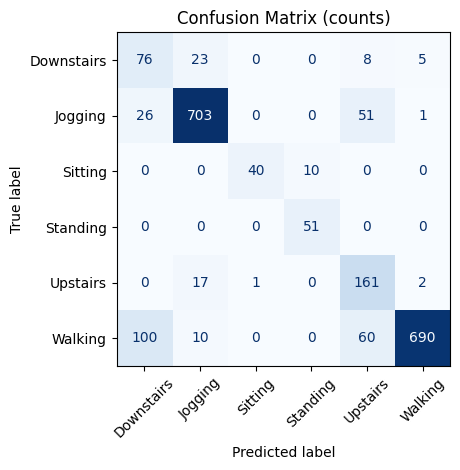

<Figure size 700x700 with 0 Axes>

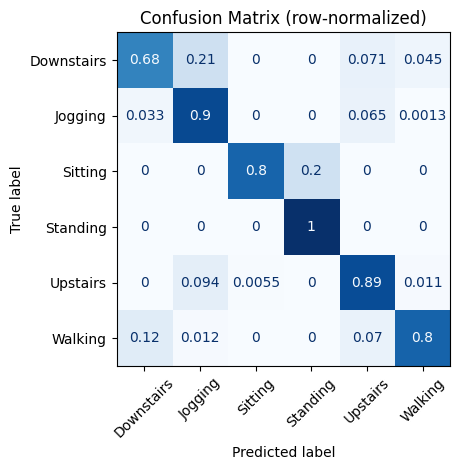

              precision    recall  f1-score   support

  Downstairs     0.3762    0.6786    0.4841       112
     Jogging     0.9336    0.9001    0.9166       781
     Sitting     0.9756    0.8000    0.8791        50
    Standing     0.8361    1.0000    0.9107        51
    Upstairs     0.5750    0.8895    0.6985       181
     Walking     0.9885    0.8023    0.8858       860

    accuracy                         0.8457      2035
   macro avg     0.7808    0.8451    0.7958      2035
weighted avg     0.8928    0.8457    0.8593      2035



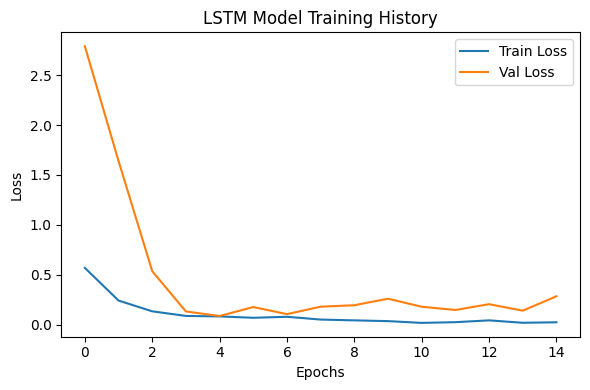

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 혼동 행렬
cm = confusion_matrix(y_te, y_pred, labels=range(len(id2lab)), normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2lab[i] for i in range(len(id2lab))])

# 일반 혼동행렬 시각화
plt.figure(figsize=(7,7))
disp.plot(include_values=True, xticks_rotation=45, cmap="Blues", colorbar=False)  # 색상 지정 (Blues 사용)
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.show()

# 정규화된 혼동 행렬
cm_norm = confusion_matrix(y_te, y_pred, labels=range(len(id2lab)), normalize="true")
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[id2lab[i] for i in range(len(id2lab))])

# 정규화 혼동행렬 시각화
plt.figure(figsize=(7,7))
disp_norm.plot(include_values=True, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout()
plt.show()

# 분류 리포트
print(classification_report(
    y_te, y_pred,
    target_names=[id2lab[i] for i in range(len(id2lab))],
    digits=4
))


# 학습 곡선 그래프 (Train/Val Loss)
def plot_history(hobj, title="Train/Val Loss"):
    h = hobj.history
    assert "loss" in h and "val_loss" in h, "loss/val_loss가 history에 없습니다."

    plt.figure(figsize=(6, 4))
    plt.plot(h["loss"], label="Train Loss")
    plt.plot(h["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 학습곡선 시각화
plot_history(history, title="LSTM Model Training History")
